In [1]:
"""
This Notebook has the implementation to read the list of xyz coordinates for the 
complex DBA.Suc, then perform the fragmentation DBA+Suc. In the DBA linker the boronic
are replaced by dummy atoms. A core fragment BO_3-Suc-BO_3 is saved for the corresponding
DBA linker to be used in the merge operation once the DBA has been mutated.
"""
from rdkit import Chem, DataStructs
from rdkit.Chem.Fraggle import FraggleSim
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdmolops
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
from rdkit.Chem import rdDepictor
from rdkit import RDConfig
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Geometry import Point3D
import csv
from random import randrange

#from rdkit import rdBase
#rdBase.DisableLog('rdApp.error')
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

import numpy as np
import random
import time
import sys

import crossover as co
import mutate as mu
import scoring_functions as sc
import xyz2mol as x2m
import PBA_mutation as PBA_mu
import os

sys.path.insert(1, 'MolGpKa/src')
#sys.path.insert(2, './MolGpKa/models')
#sys.path.insert(3, './MolGpKa/src/utils')
import protonate 

from DBA_mututation import PBA_mutation
import DBA_GA_utils

#co.average_size = 110.15
#co.size_stdev = 3.50

charged_fragments = True
quick = True

In [190]:
### Reading the directory to upload the molecules###
def dummy2BO3(mol):
    """
    Function to convert the dummy atoms *98 and *99 into boronic groups
    """
    dummy_glc = "[" + str(98) + "*]"
    dummy_frc = "[" + str(99) + "*]"
    ligBO3 = Chem.ReplaceSubstructs(mol, 
                                    Chem.MolFromSmiles(dummy_glc), 
                                    Chem.MolFromSmiles('[B-](O)(O)(O)'),
                                    replaceAll=True)

    ligBO3_2 = Chem.ReplaceSubstructs(ligBO3[0], 
                                 Chem.MolFromSmiles(dummy_frc), 
                                 Chem.MolFromSmiles('[B-](O)(O)(O)'),
                                 replaceAll=True)
    return ligBO3_2[0]

def linker_core_bonding(core,linker):
    """
    Function to bond the linker to sucrose taking into account the specific
    side of the linker bonded to the core. The dummy *98 is for the extreme of the 
    linker bonded to the glucosyl side, and the dummy *99 is for the linker side
    bonded to the fructosyl side.
    """
    cm = Chem.CombineMols(core,linker)
    dummies = []
    for atom in cm.GetAtoms():
        glcyl_side = 98
        frcyl_side = 99
        if atom.GetAtomicNum() == 0:
            dummies.append(atom.GetIdx())
            if atom.GetIsotope() == glcyl_side:
                dummies.append(atom.GetIdx())
                dummy_label = atom.GetIsotope()
                for neigh in atom.GetNeighbors():
                    if neigh.GetAtomicNum() == 6:
                        C_glc_side = neigh.GetIdx()
                    elif neigh.GetAtomicNum() == 5:
                        B_glc_side = neigh.GetIdx()
            elif atom.GetIsotope() == frcyl_side:
                dummies.append(atom.GetIdx())
                dummy_label = atom.GetIsotope()
                for neigh in atom.GetNeighbors():
                    if neigh.GetAtomicNum() == 6:
                        C_frc_side = neigh.GetIdx()
                    elif neigh.GetAtomicNum() == 5:
                        B_frc_side = neigh.GetIdx()                  
    em = Chem.RWMol(cm)
    em.BeginBatchEdit()
    em.AddBond(C_glc_side,B_glc_side,Chem.rdchem.BondType.SINGLE)
    em.AddBond(C_frc_side,B_frc_side,Chem.rdchem.BondType.SINGLE)
    for dummy in dummies:
        em.RemoveAtom(dummy)
    em.CommitBatchEdit()
    return em.GetMol()


def BCbond_4frag(atoms_idx,mol): 
    """
    Function to get the B-C bond index.
    """
    for idx in atoms_idx:
        atom = mol.GetAtomWithIdx(idx)
        if atom.GetAtomicNum() == 8:
            for neigh in atom.GetNeighbors():
                if neigh.GetAtomicNum() == 5:
                    B_idx = neigh.GetIdx()
                    for B_neigh in neigh.GetNeighbors():
                        if B_neigh.GetAtomicNum() == 6:
                            C_idx = B_neigh.GetIdx()
                            bond = mol.GetBondBetweenAtoms(B_idx, C_idx)
                            return bond.GetIdx(), B_idx

def core_linker_frag(mol,coordinates):
    """
    Function to separate the sucrose core from the linker, marking the extremes of how the linker is bonded to 
    sucrose. The dummy *98 is for the extreme of the linker bonded to the glucosyl side, and the dummy *99 is for the linker side
    bonded to the fructosyl side.
    """
    frcyl = Chem.MolFromSmarts('C1(O)C(O)C(CO)OC1(CO)')
    frcyl_idxs = mol.GetSubstructMatch(frcyl)
    glcyl = Chem.MolFromSmarts('C1C(O)C(O)C(CO)OC1(O)')
    glcyl_idxs = mol.GetSubstructMatch(glcyl)
    Glcyl_dLabel = 98
    BC_glcyl, B_idx_glcyl = BCbond_4frag(glcyl_idxs,mol) #Getting B-C bond index in glc side 
    Frcyl_dLabel = 99
    BC_frcyl, B_idx_frcyl = BCbond_4frag(frcyl_idxs,mol) #Getting B-C bond index in frc side 
    frags = Chem.FragmentOnBonds(mol, [BC_glcyl,BC_frcyl], dummyLabels=[(Glcyl_dLabel,Glcyl_dLabel),(Frcyl_dLabel,Frcyl_dLabel)])
    frag1, frag2 = Chem.GetMolFrags(frags, asMols=True)
    for atom in frag1.GetAtoms():
        if atom.GetAtomicNum() == 5:
            core = frag1 
            linker = frag2
            break
        else:
            linker = frag1
            core = frag2 
            
    suc_patt = list(frcyl_idxs + glcyl_idxs) 
    suc_patt.append(B_idx_glcyl)
    suc_patt.append(B_idx_frcyl)
    B_idxs = [B_idx_glcyl, B_idx_frcyl]
    for i in B_idxs:
        for neigh in mol.GetAtomWithIdx(i).GetNeighbors():
            if neigh.GetAtomicNum() == 8:
                if neigh.GetIdx() in suc_patt:
                    continue
                else:
                    suc_patt.append(neigh.GetIdx())
    core_coords = []
    suc_patt.sort()
    for idx in suc_patt:
        core_coords.append([mol.GetAtomWithIdx(idx).GetAtomicNum(),coordinates[idx]])
       
    return core,linker,core_coords

def linker_sanity_OK(mol,pos):
    j = 0
    if pos == 'middle':
        for atom in mol.GetAtoms():
            if atom.GetAtomicNum() == 0 and atom.GetIsotope == 96:
                j += 1
            if atom.GetAtomicNum() == 0 and atom.GetIsotope == 97:
                j += 1
        if j == 2:
            return True
        elif j < 2:
            return False

    elif pos == 'glcyl_side':
        for atom in mol.GetAtoms():
            if atom.GetAtomicNum() == 0 and atom.GetIsotope == 98:
                j += 1
            if atom.GetAtomicNum() == 0 and atom.GetIsotope == 97:
                j += 1
        if j == 2:
            return True
        elif j < 2:
            return False

    elif pos == 'frcyl_side':
        for atom in mol.GetAtoms():
            if atom.GetAtomicNum() == 0 and atom.GetIsotope == 99:
                j += 1
            if atom.GetAtomicNum() == 0 and atom.GetIsotope == 96:
                j += 1
        if j == 2:
            return True
        elif j < 2:
            return False

def linker_crossover_OK(mol):
    """
    Function to check that, after the crossover operation, both extremes of the ligands has the 
    marks *98 and *99 for the dummy atoms.
    """
    i = 0
    j = 0
    for atom in child_linker.GetAtoms():
        glcyl_side = 98
        frcyl_side = 99
        if atom.GetAtomicNum() == 0:
            if atom.GetIsotope() == glcyl_side:
                i += 1
            elif atom.GetIsotope() == frcyl_side:
                j += 1       
    #print("i =",i,"j =",j)            
    if i == 1 and j == 1:
        return True
    else:
        return False

def tweezer_clasf(mol,side):
    """
    Function to classify how the boronic groups are bonded to the linker. The types 0, 1, and 2 means that 
    the boronic groups are part of a PBA molecule in positions ortho, meta, or para, respectively. If the boronic
    group is directly bonded to the backbone of the linker, this side is classified as type 3.
    Input
    mol: Rdkit molecule with the dummy atoms as *98 and *99
    side: Strings "Glc" or "Frc" to indicate which side of the tweezer classify
    Output
    idx: 0, 1, 2, or 3
    : tuple list of atoms with the coincidences for the past
    """

    oPBA_glcyl_SMARTS = ['[#6!$([CX3]=[OX1])!$([C][CX3]=[OX1])!$([C][NX3]),#7!$([NX3;H2,O2])!$([N+]([O-])[O-])!$([#7][CX3]=[OX1]),#8!$([O][CX4;H3]),#16!H1!$([#16X4](=[OX1])(=[OX1]))]~[#6R1,#7R1]1~[#6R1](-[98*])~[#6R1,#7R1]~[#6R1,#7R1]~[#6R1,#7R1]~[#6R1,#7R1]1', \
                         '[#6!$([CX3]=[OX1])!$([C][CX3]=[OX1])!$([C][NX3]),#7!$([NX3;H2,O2])!$([N+]([O-])[O-])!$([#7][CX3]=[OX1]),#8!$([O][CX4;H3]),#16!H1!$([#16X4](=[OX1])(=[OX1]))]~[#6R1,#7R1]1~[#6R1,#7R1]~[#6R1,#7R1]~[#6R1,#7R1]~[#6R1,#7R1]~[#6R1]1(-[98*])']
    mPBA_glcyl_SMARTS = ['[#6!$([CX3]=[OX1])!$([C][CX3]=[OX1])!$([C][NX3]),#7!$([NX3;H2,O2])!$([N+]([O-])[O-])!$([#7][CX3]=[OX1]),#8!$([O][CX4;H3]),#16!H1!$([#16X4](=[OX1])(=[OX1]))]~[#6R1,#7R1]1~[#6R1,#7R1]~[#6R1](-[98*])~[#6R1,#7R1]~[#6R1,#7R1]~[#6R1,#7R1]1', \
                         '[#6!$([CX3]=[OX1])!$([C][CX3]=[OX1])!$([C][NX3]),#7!$([NX3;H2,O2])!$([N+]([O-])[O-])!$([#7][CX3]=[OX1]),#8!$([O][CX4;H3]),#16!H1!$([#16X4](=[OX1])(=[OX1]))]~[#6R1,#7R1]1~[#6R1,#7R1]~[#6R1,#7R1]~[#6R1,#7R1]~[#6R1](-[98*])~[#6R1,#7R1]1']
    pPBA_glcyl_SMARTS = ['[#6!$([CX3]=[OX1])!$([C][CX3]=[OX1])!$([C][NX3]),#7!$([NX3;H2,O2])!$([N+]([O-])[O-])!$([#7][CX3]=[OX1]),#8!$([O][CX4;H3]),#16!H1!$([#16X4](=[OX1])(=[OX1]))]~[#6R1,#7R1]1~[#6R1,#7R1]~[#6R1,#7R1]~[#6R1](-[98*])~[#6R1,#7R1]~[#6R1,#7R1]1']
    fPBA_glcyl_SMARTS = ['[#6R2,#7X3R2,#16R2]~[#6R2,#7X3R2,#16R2]~[#6R1](-[98*])', \
                         '[#6R2,#7X3R2,#16R2]~[#6R2,#7X3R2,#16R2]~[#6R1,#7R1,#16R1]~[#6R1](-[98*])']

    oPBA_frcyl_SMARTS = ['[#6!$([CX3]=[OX1])!$([C][CX3]=[OX1])!$([C][NX3]),#7!$([NX3;H2,O2])!$([N+]([O-])[O-])!$([#7][CX3]=[OX1]),#8!$([O][CX4;H3]),#16!H1!$([#16X4](=[OX1])(=[OX1]))]~[#6R1,#7R1]1~[#6R1](-[99*])~[#6R1,#7R1]~[#6R1,#7R1]~[#6R1,#7R1]~[#6R1,#7R1]1', \
                         '[#6!$([CX3]=[OX1])!$([C][CX3]=[OX1])!$([C][NX3]),#7!$([NX3;H2,O2])!$([N+]([O-])[O-])!$([#7][CX3]=[OX1]),#8!$([O][CX4;H3]),#16!H1!$([#16X4](=[OX1])(=[OX1]))]~[#6R1,#7R1]1~[#6R1,#7R1]~[#6R1,#7R1]~[#6R1,#7R1]~[#6R1,#7R1]~[#6R1]1(-[99*])']
    mPBA_frcyl_SMARTS = ['[#6!$([CX3]=[OX1])!$([C][CX3]=[OX1])!$([C][NX3]),#7!$([NX3;H2,O2])!$([N+]([O-])[O-])!$([#7][CX3]=[OX1]),#8!$([O][CX4;H3]),#16!H1!$([#16X4](=[OX1])(=[OX1]))]~[#6R1,#7R1]1~[#6R1,#7R1]~[#6R1](-[99*])~[#6R1,#7R1]~[#6R1,#7R1]~[#6R1,#7R1]1', \
                         '[#6!$([CX3]=[OX1])!$([C][CX3]=[OX1])!$([C][NX3]),#7!$([NX3;H2,O2])!$([N+]([O-])[O-])!$([#7][CX3]=[OX1]),#8!$([O][CX4;H3]),#16!H1!$([#16X4](=[OX1])(=[OX1]))]~[#6R1,#7R1]1~[#6R1,#7R1]~[#6R1,#7R1]~[#6R1,#7R1]~[#6R1](-[99*])~[#6R1,#7R1]1']
    pPBA_frcyl_SMARTS = ['[#6!$([CX3]=[OX1])!$([C][CX3]=[OX1])!$([C][NX3]),#7!$([NX3;H2,O2])!$([N+]([O-])[O-])!$([#7][CX3]=[OX1]),#8!$([O][CX4;H3]),#16!H1!$([#16X4](=[OX1])(=[OX1]))]~[#6R1,#7R1]1~[#6R1,#7R1]~[#6R1,#7R1]~[#6R1](-[99*])~[#6R1,#7R1]~[#6R1,#7R1]1']
    fPBA_frcyl_SMARTS = ['[#6R2,#7X3R2,#16R2]~[#6R2,#7X3R2,#16R2]~[#6R1](-[99*])', \
                         '[#6R2,#7X3R2,#16R2]~[#6R2,#7X3R2,#16R2]~[#6R1,#7R1,#16R1]~[#6R1](-[99*])']

    subs_glcyl_side = [oPBA_glcyl_SMARTS, mPBA_glcyl_SMARTS, pPBA_glcyl_SMARTS, fPBA_glcyl_SMARTS]
    subs_frcyl_side = [oPBA_frcyl_SMARTS, mPBA_frcyl_SMARTS, pPBA_frcyl_SMARTS, fPBA_frcyl_SMARTS]

    if side == 'Glc':
        for idx,sub_glcyl in enumerate(subs_glcyl_side):
            for smarts_sub in sub_glcyl:
                patt = Chem.MolFromSmarts(smarts_sub)
                print('Glcyl side:',idx,mol.HasSubstructMatch(patt))
                if mol.HasSubstructMatch(patt):  
                    print(mol.GetSubstructMatch(patt))
                    return idx, mol.GetSubstructMatch(patt)
    elif side == 'Frc':
        for idx,sub_frcyl in enumerate(subs_frcyl_side):
            for smarts_sub in sub_frcyl:
                patt = Chem.MolFromSmarts(smarts_sub)
                print('Frcyl side:',idx,mol.HasSubstructMatch(patt))
                if mol.HasSubstructMatch(patt):
                    print(mol.GetSubstructMatch(patt))
                    return idx, mol.GetSubstructMatch(patt)

PBAs_fps = list()
pKas_data = []
with open('PBA_data4sim.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            #print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            mol = Chem.MolFromSmiles(row[0])
            pKas_data.append(row[1])
            PBAs_fps.append(AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=4086))
            line_count += 1

def pKaFromSimmilarity(smiles,PBAs_fps,pKas_data):
    idx = 0
    max = -1
    mol = dummy2BO3_sim(Chem.MolFromSmiles(smiles))
    Chem.SanitizeMol(mol)
    fp_mol = AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=4086)
    for fp in PBAs_fps:
        Tan_sim = Chem.DataStructs.TanimotoSimilarity(fp_mol,fp)
        Cosine_sim = Chem.DataStructs.CosineSimilarity(fp_mol,fp)
        Dice_sim = Chem.DataStructs.DiceSimilarity(fp_mol,fp)
        Consensus = (Tan_sim + Cosine_sim + Dice_sim)/3
    
        if Consensus > max:
            max = Consensus
            idx_max = idx
        idx += 1
        print('pka from similarity',idx_max,max)        
    return pKas_data[idx_max]

def dummy2BO3_sim(mol):
    """
    Function to convert the dummy atoms *98 and *99 into boronic groups
    """
    dummy_glc = "[" + str(98) + "*]"
    dummy_frc = "[" + str(99) + "*]"
    dummy_H1 = "[" + str(96) + "*]"
    dummy_H2 = "[" + str(97) + "*]"
    ligBO3 = Chem.ReplaceSubstructs(mol, 
                                    Chem.MolFromSmiles(dummy_glc), 
                                    Chem.MolFromSmiles('[B-](O)(O)(O)'),
                                    replaceAll=True)

    ligBO3_2 = Chem.ReplaceSubstructs(ligBO3[0], 
                                 Chem.MolFromSmiles(dummy_frc), 
                                 Chem.MolFromSmiles('[B-](O)(O)(O)'),
                                 replaceAll=True)

    em = Chem.RWMol(ligBO3_2[0])
    em.BeginBatchEdit()
    for atom in em.GetAtoms():
        #print(atom.GetIdx(),atom.GetAtomicNum())
        if atom.GetAtomicNum() == 0:
            #print('Print dummy atom',atom.GetIdx())
            em.RemoveAtom(atom.GetIdx())
    em.CommitBatchEdit()
            
    return(em)

In [5]:
###################################################################
"""
Function to read the list file with of the complex, creating two arrays, one for the free ligand and the other for the
free ligand
"""
dir = os.getcwd()
#xyzfiles = os.listdir('data_cmplxs/')
#xyzfiles = os.listdir('m-Glc_Frc-m/')
xyzfiles = os.listdir('linkers2classify')
linkers = []
cores = []
cores_xyz = []
names = []
cmplxs = []
cmplxs_xyz = []
for xyzfile in xyzfiles:
    #file = "data_cmplxs/" + xyzfile
    #file = "m-Glc_Frc-m/" + xyzfile
    file = "linkers2classify/" + xyzfile
    print("New Liker Classsification:",xyzfile)
    names.append(str(xyzfile))
    atoms, charge_read, coordinates = x2m.read_xyz_file(file)
    chrg = -2
    if xyzfile == 'cmplx113.xyz':
        chrg = 0
    elif xyzfile == 'cmplx114.xyz':
        chrg = -1
    raw_mol = x2m.xyz2mol(atoms, coordinates, charge=chrg)
    Chem.SanitizeMol(raw_mol[0])

    #new_core, new_linkHs = core_linker_frag(Chem.MolFromSmiles(Chem.MolToSmiles(raw_mol[0])),False)
    new_core, new_linkHs, core_xyz = DBA_GA_utils.core_linker_frag(raw_mol[0],coordinates)
    new_link = Chem.RemoveHs(new_linkHs)

    new_link.SetProp('pKaglcyl',str(8.8))
    new_link.SetProp('pKafrcyl',str(8.8))
    
    #linkers.append(Chem.MolFromSmiles(Chem.MolToSmiles(new_link)))
    linkers.append(new_link)
    cores.append(new_core)
    cores_xyz.append(core_xyz)
    cmplxs.append(raw_mol[0])
    cmplxs_xyz.append(coordinates)
    # The operations for mutation should be performed inside the mutation.py file
    ## Glcosyl side
"""
    oPBA_glcyl = Chem.MolFromSmarts('[#6!$([CX3]=[OX1])!$([C][CX3]=[OX1])!$([C][NX3]),#7!$([NX3;H2,O2])!$([N+]([O-])[O-])!$([#7][CX3]=[OX1]),#8!$([O][CX4;H3]),#16!H1!$([#16X4](=[OX1])(=[OX1]))]~[#6R1,#7R1]1~[#6R1](-[98*])~[#6R1,#7R1]~[#6R1,#7R1]~[#6R1,#7R1]~[#6R1,#7R1]1')
    mPBA_glcyl = Chem.MolFromSmarts('[#6!$([CX3]=[OX1])!$([C][CX3]=[OX1])!$([C][NX3]),#7!$([NX3;H2,O2])!$([N+]([O-])[O-])!$([#7][CX3]=[OX1]),#8!$([O][CX4;H3]),#16!H1!$([#16X4](=[OX1])(=[OX1]))]~[#6R1,#7R1]1~[#6R1,#7R1]~[#6R1](-[98*])~[#6R1,#7R1]~[#6R1,#7R1]~[#6R1,#7R1]1')
    pPBA_glcyl = Chem.MolFromSmarts('[#6!$([CX3]=[OX1])!$([C][CX3]=[OX1])!$([C][NX3]),#7!$([NX3;H2,O2])!$([N+]([O-])[O-])!$([#7][CX3]=[OX1]),#8!$([O][CX4;H3]),#16!H1!$([#16X4](=[OX1])(=[OX1]))]~[#6R1,#7R1]1~[#6R1,#7R1]~[#6R1,#7R1]~[#6R1](-[98*])~[#6R1,#7R1]~[#6R1,#7R1]1')
    #ofPBA_glcyl = Chem.MolFromSmarts('[#6]1(-[98*])~[#6]~[#6]~[#6]~[#6X3H0R2]~[#6X3H0R2]1')
    #mfPBA_glcyl = Chem.MolFromSmarts('[#6]1~[#6](-[98*])~[#6]~[#6]~[#6X3H0R2]~[#6X3H0R2]1')
    #pfPBA_glcyl = Chem.MolFromSmarts('[#6]1~[#6]~[#6](-[98*])~[#6]~[#6X3H0R2]~[#6X3H0R2]1')
    ofPBA_glcyl = Chem.MolFromSmarts('[#6R2,#7X3R2,#16R2]~[#6R2,#7X3R2,#16R2]~[#6R1](-[98*])')
    mfPBA_glcyl = Chem.MolFromSmarts('[#6R2,#7X3R2,#16R2]~[#6R2,#7X3R2,#16R2]~[#6R1,#7R1,#16R1]~[#6R1](-[98*])')
    #pfPBA_glcyl = Chem.MolFromSmarts('[#6]1~[#6]~[#6](-[98*])~[#6]~[#6X3H0R2]~[#6X3H0R2]1')
    ## Fructosyl side
    oPBA_frcyl = Chem.MolFromSmarts('[#6!$([CX3]=[OX1])!$([C][CX3]=[OX1])!$([C][NX3]),#7!$([NX3;H2,O2])!$([N+]([O-])[O-])!$([#7][CX3]=[OX1]),#8!$([O][CX4;H3]),#16!H1!$([#16X4](=[OX1])(=[OX1]))]~[#6R1,#7R1]1~[#6R1](-[99*])~[#6R1,#7R1]~[#6R1,#7R1]~[#6R1,#7R1]~[#6R1,#7R1]1')
    mPBA_frcyl = Chem.MolFromSmarts('[#6!$([CX3]=[OX1])!$([C][CX3]=[OX1])!$([C][NX3]),#7!$([NX3;H2,O2])!$([N+]([O-])[O-])!$([#7][CX3]=[OX1]),#8!$([O][CX4;H3]),#16!H1!$([#16X4](=[OX1])(=[OX1]))]~[#6R1,#7R1]1~[#6R1,#7R1]~[#6R1](-[99*])~[#6R1,#7R1]~[#6R1,#7R1]~[#6R1,#7R1]1')
    #mPBA_frcyl = Chem.MolFromSmarts('[#6!$([CX3]=[OX1])!$([C][CX3]=[OX1])!$([C][NX3]),#7O0!H2!$([#7][CX3]=[OX1]),#8!$([O][CX4;H3]),#16!H1!$([#16X4](=[OX1])(=[OX1]))]~[#6R1,#7R1]1~[#6R1,#7R1]~[#6R1,#7R1]~[#6R1,#7R1]~[#6R1](-[99*])~[#6R1,#7R1]1')
    pPBA_frcyl = Chem.MolFromSmarts('[#6!$([CX3]=[OX1])!$([C][CX3]=[OX1])!$([C][NX3]),#7!$([NX3;H2,O2])!$([N+]([O-])[O-])!$([#7][CX3]=[OX1]),#8!$([O][CX4;H3]),#16!H1!$([#16X4](=[OX1])(=[OX1]))]~[#6R1,#7R1]1~[#6R1,#7R1]~[#6R1,#7R1]~[#6R1](-[99*])~[#6R1,#7R1]~[#6R1,#7R1]1')
    #ofPBA_frcyl = Chem.MolFromSmarts('[#6]1(-[99*])~[#6]~[#6]~[#6]~[#6X3H0R2]~[#6X3H0R2]1')
    #mfPBA_frcyl = Chem.MolFromSmarts('[#6]1~[#6](-[99*])~[#6]~[#6]~[#6X3H0R2]~[#6X3H0R2]1')
    #pfPBA_frcyl = Chem.MolFromSmarts('[#6]1~[#6]~[#6](-[99*])~[#6]~[#6X3H0R2]~[#6X3H0R2]1')
    ofPBA_frcyl = Chem.MolFromSmarts('[#6R2,#7X3R2,#16R2]~[#6R2,#7X3R2,#16R2]~[#6R1](-[99*])')
    mfPBA_frcyl = Chem.MolFromSmarts('[#6R2,#7X3R2,#16R2]~[#6R2,#7X3R2,#16R2]~[#6R1,#7R1,#16R1]~[#6R1](-[99*])')

    subs_glcyl_side = [oPBA_glcyl, mPBA_glcyl, pPBA_glcyl, ofPBA_glcyl, mfPBA_glcyl]#, pfPBA_glcyl]
    subs_frcyl_side = [oPBA_frcyl, mPBA_frcyl, pPBA_frcyl, ofPBA_frcyl, mfPBA_frcyl]#, pfPBA_frcyl]
    type = 0
    m = 0
    #print("New Liker Classsification:",xyzfile)
    print(Chem.MolToSmiles(Chem.RemoveHs(raw_mol[0])))
    for idx_glcyl,sub_glcyl in enumerate(subs_glcyl_side):
        for idx_frcyl,sub_frcyl in enumerate(subs_frcyl_side):
            type += 1
            print("Glcyl side:",idx_glcyl,new_link.HasSubstructMatch(sub_glcyl), \
            "Frcyl side:",idx_frcyl,new_link.HasSubstructMatch(sub_frcyl))
            if new_link.HasSubstructMatch(sub_glcyl) and new_link.HasSubstructMatch(sub_frcyl):
                print("Linker type",type)
                print(Chem.MolToSmiles(new_link))
                m += 1
                #break
                print(new_link.GetSubstructMatches(sub_glcyl))
                print(new_link.GetSubstructMatches(sub_frcyl))
            #elif idx_glcyl== 5 and idx_frcyl == 5 and m == 0:
            #    print("No classification for linker",xyzfile)
"""
Chem.SanitizeMol(new_link)
print(Chem.MolToSmiles(Chem.RemoveHs(raw_mol[0])))
Chem.MolFromSmiles(Chem.MolToSmiles(raw_mol[0]))
print('pKaglcyl =',new_link.GetProp('pKaglcyl'))

New Liker Classsification: cmplx66.xyz
New Liker Classsification: cmplx61.xyz
New Liker Classsification: cmplx100.xyz
New Liker Classsification: cmplx13.xyz
New Liker Classsification: cmplx14.xyz
New Liker Classsification: cmplx68.xyz
New Liker Classsification: cmplx21.xyz
New Liker Classsification: cmplx26.xyz
New Liker Classsification: cmplx85.xyz
New Liker Classsification: cmplx54.xyz
New Liker Classsification: cmplx28.xyz
New Liker Classsification: cmplx82.xyz
New Liker Classsification: cmplx53.xyz
New Liker Classsification: cmplx42.xyz
New Liker Classsification: cmplx93.xyz
New Liker Classsification: cmplx45.xyz
New Liker Classsification: cmplx94.xyz
New Liker Classsification: cmplx39.xyz
New Liker Classsification: cmplx2.xyz
New Liker Classsification: cmplx37.xyz
New Liker Classsification: cmplx30.xyz
New Liker Classsification: cmplx5.xyz
New Liker Classsification: cmplx79.xyz
New Liker Classsification: cmplx70.xyz
New Liker Classsification: cmplx77.xyz
New Liker Classsification:

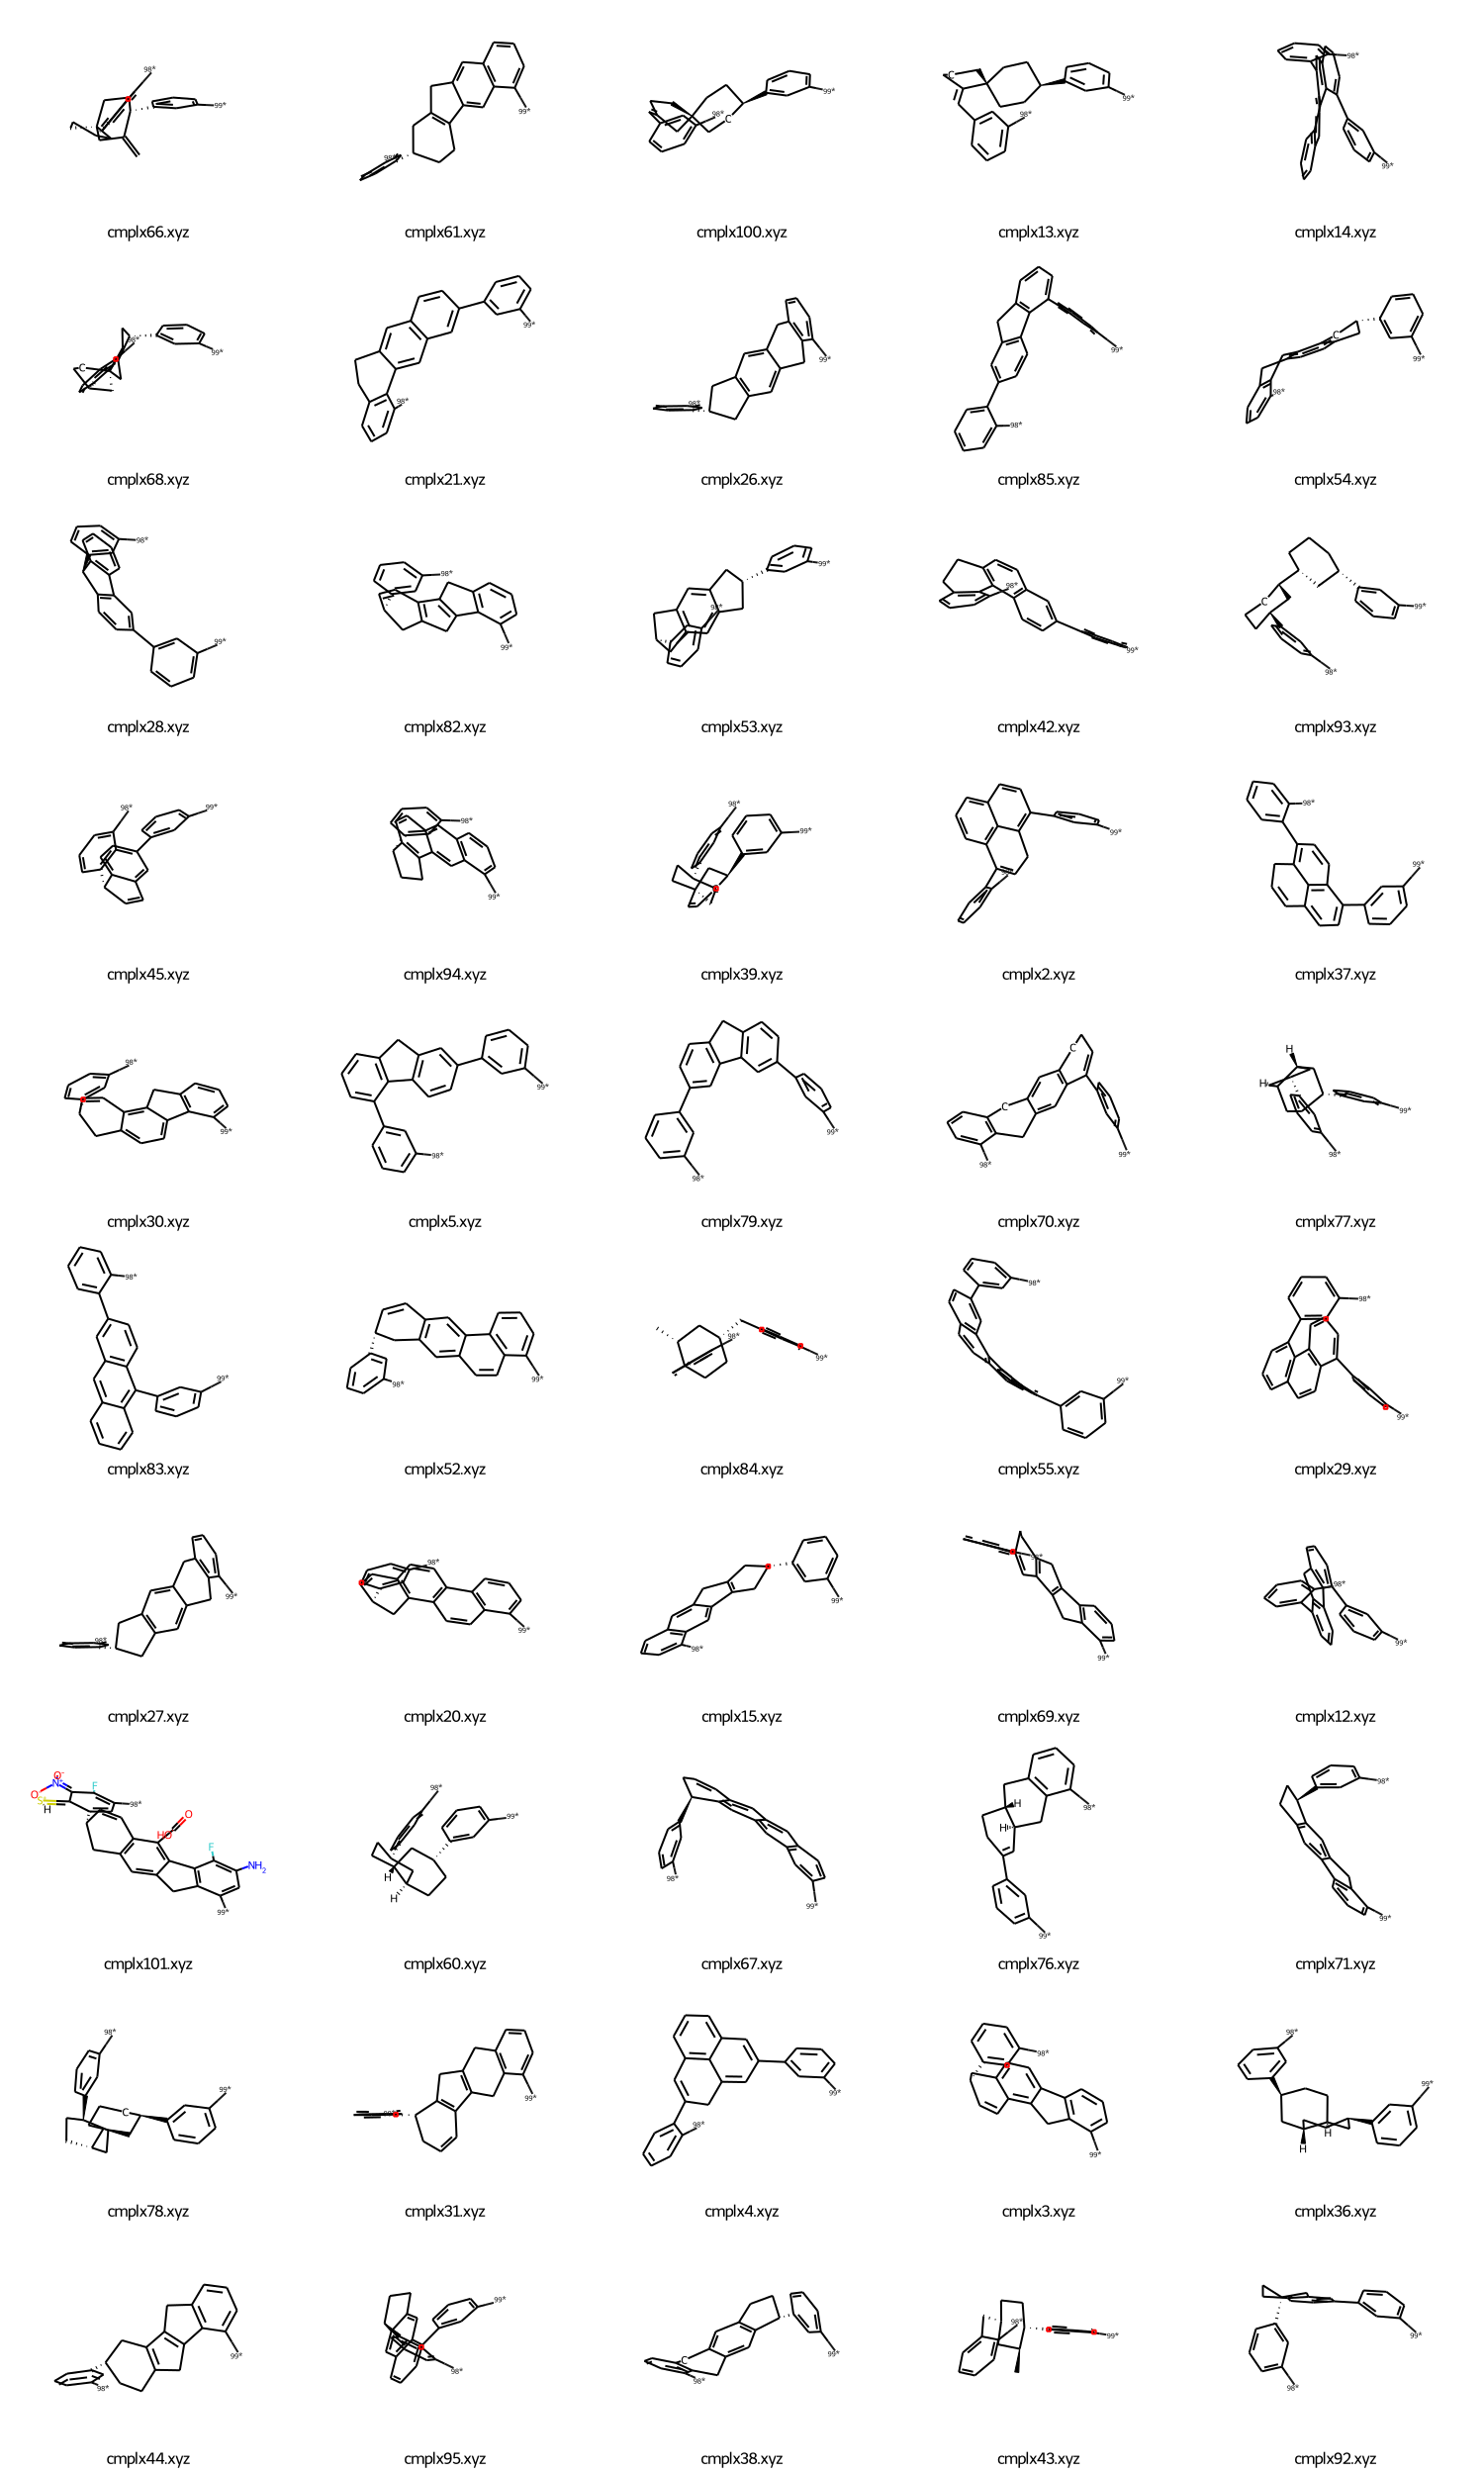

In [6]:
Draw.MolsToGridImage(linkers, molsPerRow=5, subImgSize=(300,250), legends=names)#, returnPNG=True)

In [5]:
rnd_idx = randrange(len(linkers))
#rnd_idx = 36
linker = linkers[rnd_idx]
suc_core = cores[rnd_idx]
#linker_nHs = Chem.RemoveHs(linker)
#Chem.SanitizeMol(linker)

# The operations for mutation should be performed inside the mutation.py file
## Glcosyl side

oPBA_glcyl_SMARTS=['[#6,#7]~[#6R1]1~[#6R1](-[98*])~[#6R1]~[#6R1]~[#6R1]~[#6R1]1','[#6,#7]~[#6R1]1~[#6R1]~[#6R1]~[#6R1]~[#6R1]~[#6R1]1(-[98*])']
oPBA_glcyl = Chem.MolFromSmarts('[#6,#7]~[#6R1]1~[#6R1](-[98*])~[#6R1]~[#6R1]~[#6R1]~[#6R1]1')
mPBA_glcyl_SMARTS=['[#6,#7]~[#6R1]1~[#6R1]~[#6R1](-[98*])~[#6R1]~[#6R1]~[#6R1]1','[#6,#7]~[#6R1]1~[#6R1]~[#6R1]~[#6R1]~[#6R1](-[98*])~[#6R1]1']
mPBA_glcyl = Chem.MolFromSmarts('[#6,#7]~[#6R1]1~[#6R1]~[#6R1](-[98*])~[#6R1]~[#6R1]~[#6R1]1')
#mPBA_glcyl = Chem.MolFromSmarts('[#6,#7]~[#6R1]1~[#6R1]~[#6R1]~[#6R1]~[#6R1](-[98*])~[#6R1]1')
#mPBA_glcyl = Chem.MolFromSmarts('[#6,#7][$([#6R1]1~[#6R1]~[#6R1](-[98*])~[#6R1]~[#6R1]~[#6R1]1)]')
#mPBA_glcyl = Chem.MolFromSmarts('[#6,#7][$([#6R1]1~[#6R1]~[#6R1]~[#6R1]~[#6R1](-[98*])~[#6R1]1)]')
pPBA_glcyl_SMARTS = ['[#6,#7]~[#6R1]1~[#6R1]~[#6R1]~[#6R1](-[98*])~[#6R1]~[#6R1]1']
pPBA_glcyl = Chem.MolFromSmarts('[#6,#7]~[#6R1]1~[#6R1]~[#6R1]~[#6R1](-[98*])~[#6R1]~[#6R1]1')
ofPBA_glcyl = Chem.MolFromSmarts('[#6]1(-[98*])~[#6]~[#6]~[#6]~[#6X3H0]~[#6X3H0R2]1')
mfPBA_glcyl = Chem.MolFromSmarts('[#6]1~[#6](-[98*])~[#6]~[#6]~[#6X3H0]~[#6X3H0R2]1')
pfPBA_glcyl = Chem.MolFromSmarts('[#6]1~[#6]~[#6](-[98*])~[#6]~[#6X3H0]~[#6X3H0R2]1')
## Fructosyl side
oPBA_frcyl = Chem.MolFromSmarts('[#6,#7]~[#6R1]1~[#6R1](-[99*])~[#6R1]~[#6R1]~[#6R1]~[#6R1]1')
mPBA_frcyl = Chem.MolFromSmarts('[#6,#7]~[#6R1]1~[#6R1]~[#6R1](-[99*])~[#6R1]~[#6R1]~[#6R1]1')
pPBA_frcyl = Chem.MolFromSmarts('[#6,#7]~[#6R1]1~[#6R1]~[#6R1]~[#6R1](-[99*])~[#6R1]~[#6R1]1')
ofPBA_frcyl = Chem.MolFromSmarts('[#6R1]1(-[99*])~[#6R1]~[#6R1]~[#6R1]~[#6X3H0R2]~[#6X3H0R2]1')
mfPBA_frcyl = Chem.MolFromSmarts('[#6R1]1~[#6R1](-[99*])~[#6R1]~[#6R1]~[#6X3H0R2]~[#6X3H0R2]1')
pfPBA_frcyl = Chem.MolFromSmarts('[#6]1~[#6]~[#6](-[99*])~[#6]~[#6X3H0R2]~[#6X3H0R2]1')

subs_glcyl_side = [oPBA_glcyl, mPBA_glcyl, pPBA_glcyl, ofPBA_glcyl, mfPBA_glcyl, pfPBA_glcyl]
subs_frcyl_side = [oPBA_frcyl, mPBA_frcyl, pPBA_frcyl, ofPBA_frcyl, mfPBA_frcyl, pfPBA_frcyl]
print(oPBA_glcyl_SMARTS)
type = 0
#print("New Liker Classsification:",xyzfile)
for idx_glcyl,sub_glcyl in enumerate(subs_glcyl_side):
    for idx_frcyl,sub_frcyl in enumerate(subs_frcyl_side):
        type += 1
        print("Glcyl side:",idx_glcyl,linker.HasSubstructMatch(sub_glcyl), \
        "Frcyl side:",idx_frcyl,linker.HasSubstructMatch(sub_frcyl))
        if linker.HasSubstructMatch(sub_glcyl) and linker.HasSubstructMatch(sub_frcyl):
            print("Linker type",type)
            print(linker.GetSubstructMatch(sub_glcyl))
            print(linker.GetSubstructMatch(sub_frcyl))
        elif idx_glcyl== 5 and idx_frcyl == 5:
            print("No classification for linker",rnd_idx)


#It is better implement the fragmentation algorithm in the mutatio.py routine.
#I should think about how to save the information to fragment the linkers, and easily rebond the parts,
#perform the mutation operations either on the linker or the PBA. 
"""
from rdkit import Chem

suppl = Chem.SDMolSupplier('old.sdf')

w = Chem.SDWriter('new.sdf')  # or old.sdf to overwrite

for m in suppl:
    n = m.GetProp('_Name')    # title
    m.SetProp('ID', n)        # associated data Command to associate data to the molecules. For example, the pKa or logP.
    w.write(m)                # Probably I can set the pKa once the molecule has been read as rdkit element. Also, I can associate
                              # the logP coefficient once it is calculated.
w.close()
"""
#Mutation
mutated_linker = mu.mutate(linker,1.0,)
max_chrg = 0
if linker_sanity_OK(mutated_linker,max_chrg) == True:
    print(Chem.MolToSmiles(mutated_linker))
Chem.SanitizeMol(mutated_linker)
Chem.MolFromSmiles(Chem.MolToSmiles(mutated_linker))

['[#6,#7]~[#6R1]1~[#6R1](-[98*])~[#6R1]~[#6R1]~[#6R1]~[#6R1]1', '[#6,#7]~[#6R1]1~[#6R1]~[#6R1]~[#6R1]~[#6R1]~[#6R1]1(-[98*])']
Glcyl side: 0 True Frcyl side: 0 False
Glcyl side: 0 True Frcyl side: 1 True
Linker type 2
(12, 8, 7, 26, 6, 11, 10, 9)
(21, 3, 2, 1, 27, 0, 5, 4)
Glcyl side: 0 True Frcyl side: 2 False
Glcyl side: 0 True Frcyl side: 3 False
Glcyl side: 0 True Frcyl side: 4 False
Glcyl side: 0 True Frcyl side: 5 False
Glcyl side: 1 False Frcyl side: 0 False
Glcyl side: 1 False Frcyl side: 1 True
Glcyl side: 1 False Frcyl side: 2 False
Glcyl side: 1 False Frcyl side: 3 False
Glcyl side: 1 False Frcyl side: 4 False
Glcyl side: 1 False Frcyl side: 5 False
Glcyl side: 2 False Frcyl side: 0 False
Glcyl side: 2 False Frcyl side: 1 True
Glcyl side: 2 False Frcyl side: 2 False
Glcyl side: 2 False Frcyl side: 3 False
Glcyl side: 2 False Frcyl side: 4 False
Glcyl side: 2 False Frcyl side: 5 False
Glcyl side: 3 False Frcyl side: 0 False
Glcyl side: 3 False Frcyl side: 1 True
Glcyl side: 3

TypeError: mutate() missing 1 required positional argument: 'pos'

101
98
Linker: [98*]C1=CC=CC([C@@H]2C=CC3=C(C=C4CC5=C(C=CC=C5[99*])C4=C3)C2)=C1
Glcyl side: 0 False
Glcyl side: 0 False
Glcyl side: 1 True
(21, 9, 8, 7, 23, 6, 11, 10)
Frcyl side: 0 False
Frcyl side: 0 False
Frcyl side: 1 False
Frcyl side: 1 False
Frcyl side: 2 False
Frcyl side: 3 True
(3, 2, 1, 24)
One bond breaking and two fragments
After FragOnBonds: [96*][C@@H]1C=Cc2cc3c(cc2C1)Cc1c([99*])cccc1-3.[96*]c1cccc([98*])c1
Breaking on glcyl side
Do mutation on the linker
mutation [*;!H0:1]-[*;!H0:2]>>[*:1]=[*:2]
[96*][C@@H]1C=CC2=C(C=C3CC4=C(C=C=C=C4[99*])C3=C2)C1 True False
[96*][C@@H]1C=CC2=C(C=C3CC4=C(C=C=C=C4[99*])C3=C2)C1 True False
[96*][C@@H]1=C=CC2=C(C=C3CC4=C(C=CC=C4[99*])C3=C2)C1 False False
[96*][C@@H]1=C=CC2=C(C=C3CC4=C(C=CC=C4[99*])C3=C2)C1 False False
[96*][C@H]1=CC2=C(C=C1)C=C1C(=C2)CC2=C1C=CC=C2[99*] False False
[96*][C@H]1=CC2=C(C=C1)C=C1C(=C2)CC2=C1C=CC=C2[99*] False False
mutation [*:1]~[D3](~[*;!H0:2])~[*:3]>>[*:1]-[*:2]-[*:3]
[96*][C@@H]1C=CC2=C(C=C3C(=C2)C2C=CC=C([99

/users/glara/anaconda3/envs/rdkit-env/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)
/users/glara/anaconda3/envs/rdkit-env/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


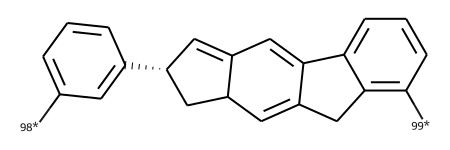

In [232]:
rnd_idx = randrange(len(linkers))
print(len(linkers))
print(rnd_idx)
#rnd_idx = 10
linker = linkers[rnd_idx]
suc_core = cores[rnd_idx]
suc_core_xyz = cores_xyz[rnd_idx]
cmplx_parent = cmplxs[rnd_idx]
cmplx_parent_xyz = cmplxs_xyz[rnd_idx]
#linker_nHs = Chem.RemoveHs(linker)
#Chem.SanitizeMol(linker)
print('Linker:',Chem.MolToSmiles(linker,kekuleSmiles=True))

# The operations for mutation should be performed inside the mutation.py file
## Glcosyl side

idx_glcyl, glcylpatt = tweezer_clasf(linker,'Glc')
idx_frcyl, frcylpatt = tweezer_clasf(linker,'Frc')

Glcyl_dLabel = 96
Frcyl_dLabel = 97
if idx_glcyl in [0,1,2] and idx_frcyl in [0,1,2]:
    print("Two bond breakings and three fragments")
    glcyl_a1, glcyl_a2 = glcylpatt[:2]
    frcyl_a1, frcyl_a2 = frcylpatt[:2]
    
    print('Atoms Glcyl side:',glcyl_a1, glcyl_a2)
    print('Atoms Frcyl side:',frcyl_a1, frcyl_a2)
    
    glcyl_bond = linker.GetBondBetweenAtoms(glcyl_a1, glcyl_a2)
    frcyl_bond = linker.GetBondBetweenAtoms(frcyl_a1, frcyl_a2)
    
    frags = Chem.FragmentOnBonds(linker, [glcyl_bond.GetIdx(),frcyl_bond.GetIdx()], \
                                          dummyLabels=[(Glcyl_dLabel,Glcyl_dLabel),(Frcyl_dLabel,Frcyl_dLabel)])
    
    print('After FragOnBonds:',Chem.MolToSmiles(frags))
    
    frag1, frag2, frag3 = Chem.GetMolFrags(frags, asMols=True)
    print('Raw fragments:',Chem.MolToSmiles(frag1),Chem.MolToSmiles(frag2),Chem.MolToSmiles(frag3))

    
    for atom in frag1.GetAtoms():
        print(atom.GetAtomicNum(), atom.GetIsotope(),atom.GetIdx())
        if atom.GetAtomicNum() == 0 and atom.GetIsotope() == 98:
            print('frag1 is PBAglc4mut')
            PBAglc4mut = frag1 
            break
        elif atom.GetAtomicNum() == 0 and atom.GetIsotope() == 99:
            print('frag1 is PBAfrc4mut')
            PBAfrc4mut = frag1
            break
        elif atom.GetAtomicNum() == 0 and atom.GetIsotope() == 96:
            for atom2 in frag1.GetAtoms():
                if atom2.GetAtomicNum() == 0 and atom2.GetIsotope() == 97:
                    print('frag1 is linker4mut')
                    linker4mut = frag1
    
    for atom in frag2.GetAtoms():
        print(atom.GetAtomicNum(), atom.GetIsotope(),atom.GetIdx())
        if atom.GetAtomicNum() == 0 and atom.GetIsotope() == 98:
            print('frag2 is PBAglc4mut')
            PBAglc4mut = frag2 
            break
        elif atom.GetAtomicNum() == 0 and atom.GetIsotope() == 99:
            print('frag2 is PBAfrc4mut')
            PBAfrc4mut = frag2
            break
        elif atom.GetAtomicNum() == 0 and atom.GetIsotope() == 96:
            for atom2 in frag2.GetAtoms():
                if atom2.GetAtomicNum() == 0 and atom2.GetIsotope() == 97:
                    print('frag2 is linker4mut')
                    linker4mut = frag2

    for atom in frag3.GetAtoms():
        print(atom.GetAtomicNum(), atom.GetIsotope(),atom.GetIdx())
        if atom.GetAtomicNum() == 0 and atom.GetIsotope() == 98:
            print('frag3 is PBAglc4mut')
            PBAglc4mut = frag3 
            break
        elif atom.GetAtomicNum() == 0 and atom.GetIsotope() == 99:
            print('frag3 is PBAfrc4mut')
            PBAfrc4mut = frag3
            break
        elif atom.GetAtomicNum() == 0 and atom.GetIsotope() == 96:
            for atom2 in frag1.GetAtoms():
                if atom2.GetAtomicNum() == 0 and atom2.GetIsotope() == 97:
                    print('frag3 is linker4mut')
                    linker4mut = frag3
            
    print('Fragments classification:',Chem.MolToSmiles(PBAglc4mut),Chem.MolToSmiles(PBAfrc4mut),Chem.MolToSmiles(linker4mut))  
            
################################################
## From here I will change this to a function ##
################################################
    p = [4/6, 1/6, 1/6] 
    mut_operation = np.random.choice(['linker', 'PBAglcyl', 'PBAfrcyl'], p=p)
    if mut_operation == 'linker':
        print("Do mutation on the linker")
        linker_mut = mu.mutate(linker4mut,1.0,'middle')
        linker_mut_smi = Chem.MolToSmiles(linker_mut, kekuleSmiles=True)
        PBAglc_child, pKaglcyl_child = PBAglc4mut, linker.GetProp('pKaglcyl')
        PBAfrc_child, pKafrcyl_child = PBAfrc4mut, linker.GetProp('pKafrcyl')
    elif mut_operation == 'PBAglcyl':
        print("Do mutation on the PBAglcyl side")
        linker_mut = linker4mut
        linker_mut_smi = Chem.MolToSmiles(linker_mut, kekuleSmiles=True)
        PBAglc_child, pKaglcyl_child = PBA_mu.Glcyl() #mutation operation for the PBA in depending on the type of substitution
        PBAfrc_child, pKafrcyl_child = PBAfrc4mut, linker.GetProp('pKafrcyl')
    elif mut_operation == 'PBAfrcyl':
        print("Do mutation on the PBAfrcyl side")
        linker_mut = linker4mut
        linker_mut_smi = Chem.MolToSmiles(linker_mut, kekuleSmiles=True)
        PBAglc_child, pKaglcyl_child  = PBAglc4mut, linker.GetProp('pKaglcyl')
        PBAfrc_child, pKafrcyl_child = PBA_mu.Frcyl() #mutation operation for the PBA in depending on the type of substitution

    if float(pKaglcyl_child) > float(pKafrcyl_child):
        pH = float(pKaglcyl_child) + 1.0
        linker_child_smi = protonate.protonate_mol(linker_mut_smi,pH,0.0)
        linker_child = Chem.MolFromSmiles(linker_child_smi[0])
    else:
        pH = float(pKafrcyl_child) + 1.0
        linker_child_smi = protonate.protonate_mol(linker_mut_smi,pH,0.0)
        linker_child = Chem.MolFromSmiles(linker_child_smi[0])
    
    #Here rebond the PBA fragments and the linker

################################################
## From here I will change this to a function ##
################################################
    cm1 = Chem.CombineMols(PBAglc_child, PBAfrc_child)
    cm = Chem.CombineMols(cm1, linker_child)
    print(Chem.MolToSmiles(cm))
    dummies = []
    atoms_glc_side = []
    atoms_frc_side = []
    for atom in cm.GetAtoms():
        glcyl_side = 96
        frcyl_side = 97
        if atom.GetAtomicNum() == 0 and atom.GetIsotope() not in [98, 99]:
            dummies.append(atom.GetIdx())
            if atom.GetIsotope() == glcyl_side:
                dummies.append(atom.GetIdx())
                for neigh in atom.GetNeighbors():
                    atoms_glc_side.append(neigh.GetIdx()) # Here append the atoms to an array
            elif atom.GetIsotope() == frcyl_side:
                dummies.append(atom.GetIdx())     
                for neigh in atom.GetNeighbors():
                    atoms_frc_side.append(neigh.GetIdx()) # Here append the atoms to an array
                    
    em = Chem.RWMol(cm)
    em.BeginBatchEdit()
    em.AddBond(atoms_glc_side[0],atoms_glc_side[1],Chem.rdchem.BondType.SINGLE)
    em.AddBond(atoms_frc_side[0],atoms_frc_side[1],Chem.rdchem.BondType.SINGLE)
    for dummy in dummies:
        em.RemoveAtom(dummy)
    em.CommitBatchEdit()
    em.SetProp('pKaglcyl',str(pKaglcyl_child))
    em.SetProp('pKafrcyl',str(pKafrcyl_child))

    #return em.GetMol()
    
else:
    print("One bond breaking and two fragments")
    if idx_glcyl in [0, 1, 2] and idx_frcyl == 3:
        glcyl_a1, glcyl_a2 = glcylpatt[:2]
        glcyl_bond = linker.GetBondBetweenAtoms(glcyl_a1, glcyl_a2)
        frags = Chem.FragmentOnBonds(linker, [glcyl_bond.GetIdx()], \
                                 dummyLabels=[(Glcyl_dLabel,Glcyl_dLabel)])

        print('After FragOnBonds:',Chem.MolToSmiles(frags))
        
        frag1, frag2 = Chem.GetMolFrags(frags, asMols=True)
        for atom in frag1.GetAtoms():
            if atom.GetAtomicNum() == 0 and atom.GetIsotope() == 98:
                PBAglc4mut = frag1 
                linker4mut = frag2
                break
            else:
                linker4mut = frag1
                PBAglc4mut = frag2
        
        print("Breaking on glcyl side")
        p = [4/6, 2/6]
        mut_operation = np.random.choice(['linker', 'PBAglcyl'], p=p)    
        if mut_operation == 'linker':
            print("Do mutation on the linker")
            linker_mut = mu.mutate(linker4mut,1.0,'frcyl')
            linker_mut_smi = Chem.MolToSmiles(linker_mut, kekuleSmiles=True)
            pKafrcyl_child = pKaFromSimmilarity(linker_mut_smi,PBAs_fps,pKas_data) # Here change for the implementation based on the similarity
            PBAglc_child, pKaglcyl_child = PBAglc4mut, linker.GetProp('pKaglcyl')
        elif mut_operation == 'PBAglcyl':
            print("Do mutation on the PBAglcyl side")
            linker_mut = linker4mut
            linker_mut_smi = Chem.MolToSmiles(linker_mut, kekuleSmiles=True)
            pKafrcyl_child = linker.GetProp('pKafrcyl') # Here change for the implementation based on the similarity
            PBAglc_child,pKaglcyl_child = PBA_mu.Glcyl() #mutation operation for the PBA in depending on the type of substitution
        #Here rebond the PBA fragment and the linker

        if float(pKaglcyl_child) > float(pKafrcyl_child):
            pH = float(pKaglcyl_child) + 1.0
            linker_child_smi = protonate.protonate_mol(linker_mut_smi,pH,0.0)
            linker_child = Chem.MolFromSmiles(linker_child_smi[0])
        else:
            pH = float(pKafrcyl_child) + 1.0
            linker_child_smi = protonate.protonate_mol(linker_mut_smi,pH,0.0)
            linker_child = Chem.MolFromSmiles(linker_child_smi[0])
        
        
        cm = Chem.CombineMols(PBAglc_child, linker_child)
        dummies = []
        atoms_glc_side = []
        for atom in cm.GetAtoms():
            glcyl_side = 96
            if atom.GetAtomicNum() == 0 and atom.GetIsotope() not in [98, 99]:
                dummies.append(atom.GetIdx())
                if atom.GetIsotope() == glcyl_side:
                    dummies.append(atom.GetIdx())
                    for neigh in atom.GetNeighbors():
                        atoms_glc_side.append(neigh.GetIdx()) # Here append the atoms to an array
                    
        em = Chem.RWMol(cm)
        em.BeginBatchEdit()
        em.AddBond(atoms_glc_side[0],atoms_glc_side[1],Chem.rdchem.BondType.SINGLE)
        for dummy in dummies:
            em.RemoveAtom(dummy)
        em.CommitBatchEdit()
        em.SetProp('pKaglcyl',str(pKaglcyl_child))
        em.SetProp('pKafrcyl',str(pKafrcyl_child))
        #return em.GetMol()
    
    elif idx_frcyl in [0, 1, 2] and idx_glcyl == 3:
        frcyl_a1, frcyl_a2 = frcylpatt[:2]
        frcyl_bond = linker.GetBondBetweenAtoms(frcyl_a1, frcyl_a2)
        frags = Chem.FragmentOnBonds(linker, [frcyl_bond.GetIdx()], \
                                 dummyLabels=[(Frcyl_dLabel,Frcyl_dLabel)])

        print('After FragOnBonds:',Chem.MolToSmiles(frags))
        
        frag1, frag2 = Chem.GetMolFrags(frags, asMols=True)
        for atom in frag1.GetAtoms():
            if atom.GetAtomicNum() == 0 and atom.GetIsotope() == 99:
                PBAfrc4mut = frag1 
                linker4mut = frag2
                break
            else:
                linker4mut = frag1
                PBAfrc4mut = frag2
                
        print("Breaking on frcyl side")
        p = [4/6, 2/6]
        mut_operation = np.random.choice(['linker', 'PBAfrcyl'], p=p)
        if mut_operation == 'linker':
            print("Do mutation on the linker")
            linker_mut = mu.mutate(linker4mut,1.0,'glcyl')
            linker_mut_smi = Chem.MolToSmiles(linker_mut, kekuleSmiles=True)
            pKaglcyl_child = pKaFromSimmilarity(linker_mut_smi,PBAs_fps,pKas_data) 
            PBAfrc_child, pKafrcyl_child = PBAfrc4mut, linker.GetProp('pKafrcyl')
        elif mut_operation == 'PBAfrcyl':
            print("Do mutation on the PBAfrcyl side")
            linker_mut = linker4mut
            linker_mut_smi = Chem.MolToSmiles(linker_mut, kekuleSmiles=True)
            pKaglcyl_child = linker.GetProp('pKaglcyl')
            PBAfrc_child, pKafrcyl_child = PBA_mu.Frcyl() #mutation operation for the PBA in depending on the type of substitution

        if float(pKaglcyl_child) > float(pKafrcyl_child):
            pH = float(pKaglcyl_child) + 1.0
            linker_child_smi = protonate.protonate_mol(linker_mut_smi,pH,0.0)
            linker_child = Chem.MolFromSmiles(linker_child_smi[0])
        else:
            pH = float(pKafrcyl_child) + 1.0
            linker_child_smi = protonate.protonate_mol(linker_mut_smi,pH,0.0)
            linker_child = Chem.MolFromSmiles(linker_child_smi[0])
                
        #Here rebond the PBA fragment and the linker
        cm = Chem.CombineMols(PBAfrc_child, linker_child)
        dummies = []
        atoms_frc_side = []
        for atom in cm.GetAtoms():
            frcyl_side = 97
            if atom.GetAtomicNum() == 0 and atom.GetIsotope() not in [98, 99]:
                dummies.append(atom.GetIdx())
                if atom.GetIsotope() == frcyl_side:
                    dummies.append(atom.GetIdx())     
                    for neigh in atom.GetNeighbors():
                        atoms_frc_side.append(neigh.GetIdx()) # Here append the atoms to an array
                    
        em = Chem.RWMol(cm)
        em.BeginBatchEdit()
        em.AddBond(atoms_frc_side[0],atoms_frc_side[1],Chem.rdchem.BondType.SINGLE)
        for dummy in dummies:
            em.RemoveAtom(dummy)
        em.CommitBatchEdit()
        em.SetProp('pKaglcyl',str(pKaglcyl_child))
        em.SetProp('pKafrcyl',str(pKafrcyl_child))

#To visualize the linker
#To visualize the fragments
print('pKaglcyl =',em.GetProp('pKaglcyl'))
print('pKafrcyl =',em.GetProp('pKafrcyl'))
#Chem.SanitizeMol(em)
print(Chem.MolToSmiles(em))
Chem.MolFromSmiles(Chem.MolToSmiles(em))

In [83]:
from rdkit.Chem.Draw import rdMolDraw2D
#PBA_glcyl = Chem.MolFromSmarts('[#6,#7]-[#6]-1=[#6]-[#6](-[$([98*])])=[#6]-[#6]=[#6]-1')
mPBA_glcyl = Chem.MolFromSmarts('[#6,#7]-[#6]-1=[#6]-[#6](-[98*])=[#6]-[#6]=[#6]-1')
fPBA_glcyl = Chem.MolFromSmarts('[#6]1(-[98*])~[#6]~[#6]~[#6]~[#6X3H0]~[#6X3H0]1')
hit_ats = list(linker.GetSubstructMatch(fPBA_glcyl))
print(hit_ats)
hit_bonds = []
for bond in fPBA_glcyl.GetBonds():
    aid1 = hit_ats[bond.GetBeginAtomIdx()]
    aid2 = hit_ats[bond.GetEndAtomIdx()]
    hit_bonds.append(linker.GetBondBetweenAtoms(aid1,aid2).GetIdx())
d = rdMolDraw2D.MolDraw2DCairo(500, 500) # or MolDraw2DCairo to get PNGs
rdMolDraw2D.PrepareAndDrawMolecule(d,linker,highlightAtoms=hit_ats,highlightBonds=hit_bonds)
d.WriteDrawingText("./atom_labels_3.png")

[7, 23, 6, 11, 10, 9, 8]


Atom idx and N: 0 0
Atom idx and N: 0 16
Value of j = 1
Atom idx and N: 0 18
Value of j = 1
Atom idx and N: 0 21
Atom idx and N: 0 1
Value of j = 1
Atom idx and N: 0 25
Value of j = 2
integrity: True
linker crossover OK: True , Natoms child linker: 26


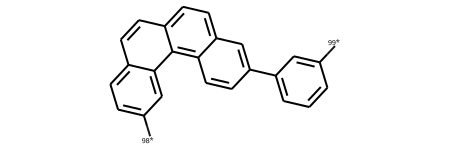

In [7]:
#Function for crossing operation. I should add a step (or an additional list) to check if 
#the new ligand is not (or has not been) in the list of ligands.
integrity = False
j = 0
while integrity == False:
    j = 0
    rnd_idx_A = randrange(len(linkers))
    suc_core_A = cores[rnd_idx_A]
    parent_A = linkers[rnd_idx_A]
    rnd_idx_B = randrange(len(linkers))
    suc_core_B = cores[rnd_idx_B]
    parent_B = linkers[rnd_idx_B]
    child_linker = co.crossover(parent_A,parent_B)
    if 12 < child_linker.GetNumAtoms() < 40:
        for atom in child_linker.GetAtoms():
            if atom.GetAtomicNum() == 0 and atom.GetIsotope() == 98 or atom.GetIsotope() == 99:
                print('Atom idx and N:',atom.GetAtomicNum(),atom.GetIdx())
                for neigh in atom.GetNeighbors():
                    if neigh.GetAtomicNum() == 6:
                        if neigh.GetIsAromatic() == True and neigh.IsInRing() == True:
                            j += 1
                            print('Value of j =',j)
    if j == 2:
        integrity = linker_crossover_OK(child_linker)
        print('integrity:',integrity)
        print('linker crossover OK:',linker_crossover_OK(child_linker),', Natoms child linker:',child_linker.GetNumAtoms())

Chem.SanitizeMol(child_linker)
Chem.MolFromSmiles(Chem.MolToSmiles(child_linker))

In [59]:
#Function bonding the new linker to the core
mutated_linker = em
mutated_linker.UpdatePropertyCache(strict=False)
Chem.SanitizeMol(mutated_linker)
cmplx_mut = linker_core_bonding(suc_core, mutated_linker)
cmplx_mut.UpdatePropertyCache(strict=False)
cmplxh_mut = Chem.AddHs(cmplx_mut, addCoords=True)
cmplxh_parent = Chem.AddHs(cmplx_parent, addCoords=True)
Chem.SanitizeMol(cmplxh_mut)
Chem.SanitizeMol(cmplxh_parent)

#cmplx_parent_xyz coordinates of the parent complex 
#suc_core_xyz coordinates of the selected core
#suc_core is selected from cores array 

suc_core_4patt = Chem.RWMol(suc_core)
suc_core_4patt.BeginBatchEdit()
for atom in suc_core_4patt.GetAtoms():
    #print(atom.GetIdx(),atom.GetAtomicNum())
    if atom.GetAtomicNum() == 0:
        #print('Print dummy atom',atom.GetIdx())
        suc_core_4patt.RemoveAtom(atom.GetIdx())
suc_core_4patt.CommitBatchEdit()
Chem.SanitizeMol(suc_core_4patt)
suc_core_mol = suc_core_4patt.GetMol()

#AllChem.EmbedMolecule(cmplxh_mut)
AllChem.EmbedMolecule(cmplxh_parent)

for i in range(cmplxh_parent.GetNumAtoms()):
    x,y,z = cmplx_parent_xyz[i]
    cmplxh_parent.GetConformer().SetAtomPosition(i,Point3D(x,y,z))

match_child = cmplxh_mut.GetSubstructMatch(suc_core_mol)
match_parent = cmplxh_parent.GetSubstructMatch(suc_core_mol)
print(match_child)
print(match_parent)

#AllChem.AlignMol(cmplxh_mut,cmplxh_parent,atomMap = list(zip(match_child,match_parent)))
#AllChem.AlignMol(cmplxh_mut,cmplxh_parent)

cmap = {match_child[i]:cmplxh_parent.GetConformer().GetAtomPosition(match_parent[i]) for i in range(len(match_parent))}
AllChem.EmbedMolecule(cmplxh_mut,randomSeed=0xf00d,coordMap=cmap,useRandomCoords=True)

from rdkit.Chem import rdForceFieldHelpers

# Perform UFF optimization
#ff = AllChem.UFFGetMoleculeForceField(cmplxh_mut)
#ff.Initialize()
#ff.Minimize(energyTol=1e-7,maxIts=100000)

mcp = Chem.Mol(cmplxh_mut)
#mmffps = rdForceFieldHelpers.UFFGetMoleculeProperties(mcp)
ff = rdForceFieldHelpers.UFFGetMoleculeForceField(mcp)
for atidx in match_child:
    print('atidx:',atidx)
    ff.UFFAddPositionConstraint(atidx,0.05,200)
maxIters = 10
while ff.Minimize(maxIts=1000) and maxIters>0:
    maxIters -= 1

print('Coordinates parent')
print(cmplxh_parent.GetNumAtoms())
print()
for i, atom in enumerate(cmplxh_parent.GetAtoms()):
    positions = cmplxh_parent.GetConformer().GetAtomPosition(i)
    print(atom.GetSymbol(), positions.x, positions.y, positions.z) 

print('Coordinates child')
print(cmplxh_mut.GetNumAtoms())
print()
for i, atom in enumerate(cmplxh_mut.GetAtoms()):
    positions = cmplxh_mut.GetConformer().GetAtomPosition(i)
    print(atom.GetSymbol(), positions.x, positions.y, positions.z) 

print('Coordinates child UFF optimization')
print(mcp.GetNumAtoms())
print()
for i, atom in enumerate(mcp.GetAtoms()):
    positions = mcp.GetConformer().GetAtomPosition(i)
    print(atom.GetSymbol(), positions.x, positions.y, positions.z) 
    
#I should check the structural integrity of the ligands after the optimization.

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46)
(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 29, 30, 37, 38, 39, 44, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66)
atidx: 0
atidx: 1
atidx: 2
atidx: 3
atidx: 4
atidx: 5
atidx: 6
atidx: 7
atidx: 8
atidx: 9
atidx: 10
atidx: 11
atidx: 12
atidx: 13
atidx: 14
atidx: 15
atidx: 16
atidx: 17
atidx: 18
atidx: 19
atidx: 20
atidx: 21
atidx: 22
atidx: 23
atidx: 24
atidx: 25
atidx: 26
atidx: 27
atidx: 28
atidx: 29
atidx: 30
atidx: 31
atidx: 32
atidx: 33
atidx: 34
atidx: 35
atidx: 36
atidx: 37
atidx: 38
atidx: 39
atidx: 40
atidx: 41
atidx: 42
atidx: 43
atidx: 44
atidx: 45
atidx: 46
Coordinates parent
91

O -1.7635 1.63313 1.31052
C -0.39277 1.9776 1.24717
O -0.22189 3.34719 1.06067
C -0.13242 3.62917 -0.34804
C -1.06976 4.75822 -0.72464
O -2.43384 4.44186 -0.65

In [81]:
mutated_linker = em
cmplx_mut = linker_core_bonding(suc_core, mutated_linker)
linkmutBO3_2 = dummy2BO3(mutated_linker)

print(Chem.MolToSmiles(linker))
print(Chem.MolToSmiles(mutated_linker))
print(Chem.MolToSmiles(linkmutBO3_2))
print(Chem.MolToSmiles(cmplx_mut))

#Chem.SanitizeMol(mutated_linker)
#Chem.MolFromSmiles(Chem.MolToSmiles(mutated_linker))
#Chem.SanitizeMol(cm)
#Chem.MolFromSmiles(Chem.MolToSmiles(cm))

#cmplx_mut2 = Chem.MolFromMolBlock(cmplx_mut, sanitize=False)
cmplx_mut.UpdatePropertyCache(strict=False)
cmplxh_mut = Chem.AddHs(cmplx_mut, addCoords=True)
print(cmplxh_mut.GetNumAtoms())
AllChem.EmbedMolecule(cmplxh_mut)
#AllChem.UFFOptimizeMolecule(cmplx_mut)
cmplxh_mut.GetConformer()
print()

for i, atom in enumerate(cmplxh_mut.GetAtoms()):
    positions = cmplxh_mut.GetConformer().GetAtomPosition(i)
    print(atom.GetSymbol(), positions.x, positions.y, positions.z) 

[98*]C1=CC=CC([C@H]2CC=CC3=C2CC2=CC4=C(C=C23)C([99*])=CC=C4)=C1
[98*]c1cccc([C@H]2CC=CC=C2Cc2ccc3c([99*])cccc3c2)c1
O[B-](O)(O)c1cccc([C@H]2CC=CC=C2Cc2ccc3c([B-](O)(O)O)cccc3c2)c1
[H]O[B@-]12OC([H])([H])[C@@]3([H])O[C@]([H])(O[C@]45O[C@]([H])(C([H])([H])O[H])[C@@]([H])(O[H])[C@]4([H])O[B@@-](O[H])(OC5([H])[H])c4cccc5cc(ccc45)CC4=CC=CC[C@@H]4c4cccc1c4)[C@]([H])(O[H])[C@@]([H])(O[H])[C@]3([H])O2
88

O 3.9391273853143334 -1.4728925794521746 -0.06828728374769129
C 4.1230723525957895 -0.37684858852577174 -0.853994921243091
O 5.37903761670093 -0.5805183295378719 -1.432091788452426
C 6.322328525344942 -0.39972094608848124 -0.42125337511675237
C 6.832822447139303 -1.6931085122324263 0.13302985212330745
O 7.433669259014666 -2.4323618169328154 -0.8831062727832388
C 5.632090079330998 0.44007986973756574 0.6638327065732922
O 6.459128727714573 1.5564947304650965 0.9269371266852976
C 4.4715180957487926 0.9144113111154214 -0.12606757747193384
O 3.4541119252595363 1.5316683320760587 0.4586929773731188

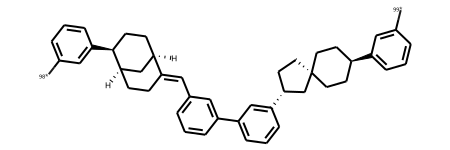

In [23]:
#mutated_ligand = Chem.MolFromSmiles('[H]C1=C([H])C2=C(C([37H])=C1[H])C([H])([H])C1=C2C2=C(C([H])=C1[H])C([H])([H])[C@]([H])(C1=C([H])C([29H])=Br([H])C([H])=C1[H])C([H])=C2[H]')
Chem.SanitizeMol(mutated_linker)
Chem.MolFromSmiles(Chem.MolToSmiles(child_linker))
#Chem.MolToSmiles(linker)

mol <rdkit.Chem.rdchem.Mol object at 0x1518d5b08270> [98*]c1cccc([C@H]2CC[C@@H]3C[C@H]2CNC(=O)C(OC)/C3=C\c2cccc([99*])c2)c1 True
mol <rdkit.Chem.rdchem.Mol object at 0x1518d55d2e30> [98*]c1cccc([C@H]2CC[C@@H]3C[C@H]2CC(OC)C(=O)N/C3=C\c2cccc([99*])c2)c1 True
mol <rdkit.Chem.rdchem.Mol object at 0x1518d55d3530> [98*]c1cccc([C@H]2CC[C@@H]3C[C@H]2CC(=O)NC(OC)/C3=C\c2cccc([99*])c2)c1 True
mol <rdkit.Chem.rdchem.Mol object at 0x1518d55d35a0> [98*]c1cccc([C@H]2CC[C@@H]3C[C@H]2NC(=O)CC(OC)/C3=C\c2cccc([99*])c2)c1 True
mol <rdkit.Chem.rdchem.Mol object at 0x1518d55d36f0> [98*]c1cccc([C@H]2CC[C@@H]3C[C@H]2CC(OC)NC(=O)/C3=C\c2cccc([99*])c2)c1 True
mol <rdkit.Chem.rdchem.Mol object at 0x1518d55d3760> [98*]c1cccc([C@H]2CC[C@@H]3C[C@H]2CC(OC)C(=Cc2cccc([99*])c2)C(=O)N3)c1 True
mol <rdkit.Chem.rdchem.Mol object at 0x1518d55d37d0> [98*]c1cccc([C@H]2CC[C@@H]3C[C@H]2CC(OC)C3C(=O)NCc2cccc([99*])c2)c1 True
mol <rdkit.Chem.rdchem.Mol object at 0x1518d55d3840> [98*]c1cccc([C@H]2CC[C@@H]3C[C@H]2C(=O)NCC(OC)/

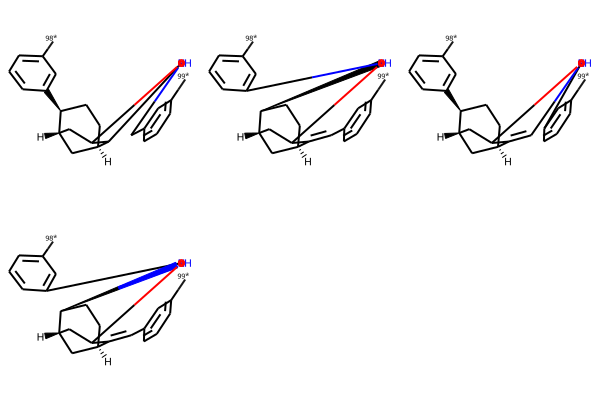

In [13]:
from rdkit.Chem import rdMolDescriptors
rxn_smarts = '[*;r6:1]~[#6:2]>>[*;r6:1][CX3:3](=[OX1:5])[NX3:6][#6:2]'
#rxn_smarts = '[*;!D3;!H0:1]>>[*;!D3:1][O:2][C:3]'
rxn = AllChem.ReactionFromSmarts(rxn_smarts)
new_mol_trial = rxn.RunReactants((mutated_linker,))
new_mols = []
for m in new_mol_trial:
    m = m[0]
    #Chem.SanitizeMol(m)
    print('mol',m,Chem.MolToSmiles(m),co.mol_OK(m))
    if co.mol_OK(m) and co.ring_OK(m):
        new_mols.append(m)
        
Draw.MolsToGridImage(new_mols)

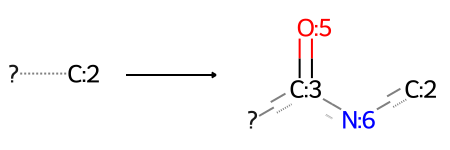

In [14]:
from rdkit.Chem import rdChemReactions
tf1 = rdChemReactions.ReactionFromSmarts(rxn_smarts)
tf1

In [34]:
patt = Chem.MolFromSmarts('[*;r6:1]~[#6:2]')
print(linker.HasSubstructMatch(patt))
linker.GetSubstructMatch(patt)
print('mol',linker,Chem.MolToSmarts(linker),co.mol_OK(linker))
print('mol',Chem.MolToSmiles(linker))

True
mol <rdkit.Chem.rdchem.Mol object at 0x14836c5e11e0> [#6]1=[#6](-[#6]=[#6](-[#6]=[#6]-1)-[#6]1-[#6]=[#6]2-[#6](=[#6]-[#6]=1)-[#6]-[#6]-[#6@@H](-[#6]1=[#6]-[#6](=[#6]-[#6]=[#6]-1)-[98#0])-[#6]-2)-[99#0] True
mol [98*]c1cccc([C@@H]2CCc3ccc(-c4cccc([99*])c4)cc3C2)c1


In [ ]:
img = Draw.MolsToGridImage(linkers,molsPerRow=5,subImgSize=(200,100))
img

In [ ]:
#!jupyter nbconvert --to script Untitled.ipynb